<a href="https://colab.research.google.com/github/martinpdab/asapa/blob/main/machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sklearn

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import  train_test_split
from keras.utils.np_utils import to_categorical

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [3]:
URL = 'https://raw.githubusercontent.com/martinpdab/asapa/main/dataset/dataset-kasus-shuffled%20(1).csv'
dataframe = pd.read_csv(URL)
dataframe

,tempat,jenis,banyak_kekerasan,banyak_korban,usia,hubungan_pelaku,label
0,rumah-tangga,seksual,1,1,remaja,orang-tua,2
1,fasilitas-umum,seksual,1,1,dewasa,lainnya,1
2,rumah-tangga,penelantaran,1,1,balita,keluarga/saudara,2
3,rumah-tangga,psikis,1,1,remaja,orang-tua,0
4,rumah-tangga,fisik,1,1,remaja,orang-tua,2
...,...,...,...,...,...,...,...
5214,rumah-tangga,seksual,1,1,dewasa,majikan,2
5215,rumah-tangga,psikis,1,1,dewasa,keluarga/saudara,0
5216,fasilitas-umum,lainnya,1,1,balita,keluarga/saudara,2
5217,rumah-tangga,psikis,1,1,dewasa,tetangga,0


In [4]:
list(dataframe["label"].unique())

[2, 1, 0]

In [5]:
dataframe.columns

Index(['tempat', 'jenis', 'banyak_kekerasan', 'banyak_korban', 'usia',
       'hubungan_pelaku', 'label'],
      dtype='object')

In [6]:
train, test = train_test_split(dataframe, test_size=0.1)
print(len(train), 'train examples')
print(len(test), 'test examples')

4697 train examples
522 test examples


In [7]:
def df_to_dataset(dataframe, batch_size=32):
    dataframe = dataframe.copy()
#     labels = dataframe.pop('Species') 
    #########
    labels = dataframe['label'].to_numpy() # please change this to your label column
    labels = tf.one_hot(labels, 3)
    #########
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.batch(batch_size)
    return ds

In [8]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
test_ds = df_to_dataset(test, batch_size=batch_size)

In [9]:
# Dataset example
# You can notice that label is one hot encoded data
for feature_batch, label_batch in train_ds.take(1):
    print("Tempat kejadian:", feature_batch["tempat"])
    print("Jenis kekerasan:", feature_batch["jenis"])
    print("Mitigasi resiko:", label_batch)
    
for feature_batch, label_batch in test_ds.take(1):
    print("Tempat kejadian:", feature_batch["tempat"])
    print("Jenis kekerasan:", feature_batch["jenis"])
    print("Mitigasi resiko:", label_batch)

Tempat kejadian: tf.Tensor(
[b'lainnya' b'rumah-tangga' b'rumah-tangga' b'rumah-tangga'
 b'rumah-tangga'], shape=(5,), dtype=string)
Jenis kekerasan: tf.Tensor([b'fisik' b'fisik' b'seksual' b'fisik' b'psikis'], shape=(5,), dtype=string)
Mitigasi resiko: tf.Tensor(
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]], shape=(5, 3), dtype=float32)
Tempat kejadian: tf.Tensor(
[b'tempat-kerja' b'fasilitas-umum' b'rumah-tangga' b'rumah-tangga'
 b'rumah-tangga'], shape=(5,), dtype=string)
Jenis kekerasan: tf.Tensor([b'seksual' b'lainnya' b'fisik' b'fisik' b'penelantaran'], shape=(5,), dtype=string)
Mitigasi resiko: tf.Tensor(
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]], shape=(5, 3), dtype=float32)


In [10]:
for feature_batch, label_batch in train_ds.take(1):
  print('Parameter:', list(feature_batch.keys()))
  print('Tempat Kejadian:', feature_batch['tempat'])
  print('Jenis Kekerasan:', feature_batch['jenis'])
  print('Banyak Kekerasan:', feature_batch['banyak_kekerasan'])
  print('Banyak Korban:', feature_batch['banyak_korban'])
  print('Usia Korban:', feature_batch['usia'])
  print('Hubungan Pelaku dengan Korban:', feature_batch['hubungan_pelaku'])
  print('Label:', label_batch )

Parameter: ['tempat', 'jenis', 'banyak_kekerasan', 'banyak_korban', 'usia', 'hubungan_pelaku', 'label']
Tempat Kejadian: tf.Tensor(
[b'lainnya' b'rumah-tangga' b'rumah-tangga' b'rumah-tangga'
 b'rumah-tangga'], shape=(5,), dtype=string)
Jenis Kekerasan: tf.Tensor([b'fisik' b'fisik' b'seksual' b'fisik' b'psikis'], shape=(5,), dtype=string)
Banyak Kekerasan: tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int64)
Banyak Korban: tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int64)
Usia Korban: tf.Tensor([b'remaja' b'anak-anak' b'remaja' b'balita' b'remaja'], shape=(5,), dtype=string)
Hubungan Pelaku dengan Korban: tf.Tensor([b'tetangga' b'keluarga/saudara' b'orang-tua' b'orang-tua' b'orang-tua'], shape=(5,), dtype=string)
Label: tf.Tensor(
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]], shape=(5, 3), dtype=float32)


In [45]:
feature_columns = []

feature_columns.append(feature_column.numeric_column('banyak_korban'))
banyak_kekerasan = feature_column.numeric_column('banyak_kekerasan')
feature_columns.append(banyak_kekerasan)

'''tempat_kejadian = tf.feature_column.categorical_column_with_vocabulary_list(
                'tempat', ['rumah-tangga', 'tempat-kerja', 'sekolah', 'fasilitas-umum', 'lainnya'])
tempat_one_hot = tf.feature_column.indicator_column(tempat_kejadian)
feature_columns.append(tempat_one_hot)'''

jenis_kekerasan = tf.feature_column.categorical_column_with_vocabulary_list(
    'jenis', ['fisik', 'seksual', 'psikis', 'penelantaran', 'lainnya', 'eksploitasi', 'traficking'])
jenis_one_hot = tf.feature_column.indicator_column(jenis_kekerasan)
feature_columns.append(jenis_one_hot)

usia_korban = tf.feature_column.categorical_column_with_vocabulary_list(
    'usia', ['balita', 'anak-anak', 'remaja', 'dewasa', 'lansia'])
usia_one_hot = tf.feature_column.indicator_column(usia_korban)
feature_columns.append(usia_one_hot)

hubungan_pelaku = tf.feature_column.categorical_column_with_vocabulary_list(
    'hubungan_pelaku', ['orang-tua', 'keluarga/saudara', 'tetangga', 'suami/istri', 'majikan', 'rekan-kerja', 'guru', 'pacar/teman', 'lainnya'])
hubungan_one_hot = tf.feature_column.indicator_column(hubungan_pelaku)
feature_columns.append(hubungan_one_hot)



feature_columns

[NumericColumn(key='banyak_korban', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='banyak_kekerasan', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='jenis', vocabulary_list=('fisik', 'seksual', 'psikis', 'penelantaran', 'lainnya', 'eksploitasi', 'traficking'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='usia', vocabulary_list=('balita', 'anak-anak', 'remaja', 'dewasa', 'lansia'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='hubungan_pelaku', vocabulary_list=('orang-tua', 'keluarga/saudara', 'tetangga', 'suami/istri', 'majikan', 'rekan-kerja', 'guru', 'pacar/teman', 'lainnya'), dtype=tf.string, default_value=-1, num_oov_buckets=0))]

In [46]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
feature_layer

In [47]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
test_ds = df_to_dataset(test, batch_size=batch_size)

In [48]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('accuracy') > 0.95):
                print("\nReached 99% accuracy so cancelling training!")
                self.model.stop_training = True

callbacks = myCallback()

In [49]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_ds,
                  validation_data=test_ds,
                  callbacks = [callbacks],
                  epochs=25)

Epoch 1/25
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
143/147 [============================>.] - ETA: 0s - loss: 0.5703 - accuracy: 0.7723WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'tempat': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=string>, 'jenis': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=string>, 'banyak_kekerasan': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'banyak_korban': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=int64>, 'usia': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=string>, 'hubungan_pelaku': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=string>, 'label': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=int64>}
Consider rewriting this model with the Functional API.
147/147 [==============================] - 2s 6ms/step - loss: 0.5652 - accuracy: 0.7747 - val_loss: 0.4293 - va

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


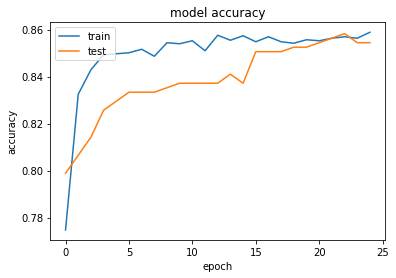

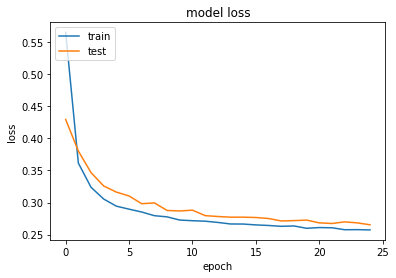

In [50]:
import matplotlib.pyplot as plt
import numpy

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

17/17 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9904
Accuracy 0.99042147397995


Untuk mengkonversi ke tensorflowjs

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 7.1MB/s 
     |████████████████████████████████| 112kB 33.3MB/s 
  Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0


In [ ]:
import time
saved_model_path = "./{}.h5".format(int(time.time()))

model.save(saved_model_path)

In [ ]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

2021-06-03 06:18:19.112349: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
